In [ ]:
import os
import pandas as pd

dataset_path = "/kaggle/input/finalhope/FINALDATASET"

def count_images(base_path):
    letter_counts = {}
    for category in os.listdir(base_path):  
        category_path = os.path.join(base_path, category)
        if not os.path.isdir(category_path):
            continue
        for letter in os.listdir(category_path):  
            letter_path = os.path.join(category_path, letter)
            if os.path.isdir(letter_path):
                image_count = sum(
                    len(files) for _, _, files in os.walk(letter_path)
                    if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in files)
                )
                letter_counts[f"{category}/{letter}"] = image_count
    return letter_counts


counts = count_images(dataset_path)


df = pd.DataFrame(list(counts.items()), columns=["Class", "Image_Count"])
df = df.sort_values(by="Image_Count", ascending=False).reset_index(drop=True)


print(df)


df.to_csv("telugu_class_counts.csv", index=False)
print("\n✅ Saved class counts to telugu_class_counts.csv")


           Class  Image_Count
0      achulu/aa          945
1    hallulu/ana          674
2     hallulu/ch          671
3      hallulu/r          670
4   hallulu/thah          669
5    hallulu/dha          659
6     hallulu/dh          655
7     hallulu/th          646
8    hallulu/cha          640
9    hallulu/tha          617
10   hallulu/jha          604
11    hallulu/da          603
12    hallulu/bh          602
13     achulu/uu          599
14    hallulu/sa          596
15      achulu/u          594
16     achulu/ii          594
17    hallulu/gh          592
18     hallulu/b          591
19      achulu/e          588
20    hallulu/rr          582
21     achulu/am          581
22     hallulu/m          579
23    hallulu/ll          579
24      achulu/a          579
25     hallulu/l          578
26     achulu/ru          578
27     hallulu/P          577
28     hallulu/n          574
29      achulu/o          574
30     achulu/oo          573
31     achulu/ao          573
32     hal

In [ ]:
import os
import random
import shutil
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


src_root = "/kaggle/input/finalhope/FINALDATASET"   
balanced_root = "/kaggle/working/balanced_52"       
final_root = "/kaggle/working/dataset_70_20_10"     
target_per_class = 500                              
split_ratios = {"train": 0.7, "val": 0.2, "test": 0.1}  


augmenter = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    fill_mode="nearest"
)


def augment_images_to_target(folder_path, target_count):
    imgs = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not imgs:
        print(f"⚠️ Skipping empty folder: {folder_path}")
        return
    img_paths = [os.path.join(folder_path, f) for f in imgs]
    current_count = len(imgs)
    print(f"✨ Augmenting {folder_path} from {current_count} → {target_count}")
    while current_count < target_count:
        img_path = random.choice(img_paths)
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        for batch in augmenter.flow(
            x, batch_size=1, save_to_dir=folder_path,
            save_prefix="aug", save_format="png"
        ):
            break
        current_count += 1
    print(f"✅ {folder_path}: now {current_count} images")


os.makedirs(balanced_root, exist_ok=True)

print("\n🧩 Step 1: Balancing classes to 500 images each...\n")

for category in ["achulu", "hallulu"]:
    cat_path = os.path.join(src_root, category)
    dst_cat = os.path.join(balanced_root, category)
    os.makedirs(dst_cat, exist_ok=True)

    for letter in os.listdir(cat_path):
        letter_path = os.path.join(cat_path, letter)
        if not os.path.isdir(letter_path):
            continue
        dst_letter = os.path.join(dst_cat, letter)
        os.makedirs(dst_letter, exist_ok=True)

        imgs = [f for f in os.listdir(letter_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        count = len(imgs)

        if count > target_per_class:
            selected = random.sample(imgs, target_per_class)
            for img in selected:
                shutil.copy(os.path.join(letter_path, img),
                            os.path.join(dst_letter, img))
            print(f"🧹 {category}/{letter}: trimmed {count} → {target_per_class}")

        elif count < target_per_class:
            for img in imgs:
                shutil.copy(os.path.join(letter_path, img),
                            os.path.join(dst_letter, img))
            print(f"⚡ {category}/{letter}: augmenting from {count}")
            augment_images_to_target(dst_letter, target_per_class)
        else:
            for img in imgs:
                shutil.copy(os.path.join(letter_path, img),
                            os.path.join(dst_letter, img))
            print(f"✅ {category}/{letter}: already 500")

print("\n✅ Step 1 Complete — All classes balanced to 500 images.\n")

print("🧩 Step 2: Splitting into train/val/test (70/20/10)...\n")

for category in ["achulu", "hallulu"]:
    cat_path = os.path.join(balanced_root, category)
    for letter in os.listdir(cat_path):
        letter_path = os.path.join(cat_path, letter)
        imgs = [f for f in os.listdir(letter_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(imgs)
        n = len(imgs)
        n_train = int(n * split_ratios["train"])
        n_val = int(n * split_ratios["val"])

        splits = {
            "train": imgs[:n_train],
            "val": imgs[n_train:n_train+n_val],
            "test": imgs[n_train+n_val:]
        }

        for split, files in splits.items():
            dst_dir = os.path.join(final_root, split, category, letter)
            os.makedirs(dst_dir, exist_ok=True)
            for f in files:
                shutil.copy(os.path.join(letter_path, f),
                            os.path.join(dst_dir, f))

print("\n✅ Step 2 Complete — Dataset split created at:", final_root)


print("\n🧩 Step 3: Verifying counts for each class...\n")

def count_images(base_path):
    data = []
    for split in ["train", "val", "test"]:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            continue
        for category in ["achulu", "hallulu"]:
            cat_path = os.path.join(split_path, category)
            for letter in os.listdir(cat_path):
                letter_path = os.path.join(cat_path, letter)
                num_imgs = len([
                    f for f in os.listdir(letter_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ])
                data.append({
                    "Category": category,
                    "Letter": letter,
                    "Split": split,
                    "Image_Count": num_imgs
                })
    return pd.DataFrame(data)

df = count_images(final_root)
summary = df.pivot_table(index=["Category","Letter"], columns="Split",
                         values="Image_Count", fill_value=0).reset_index()
summary["Total"] = summary["train"] + summary["val"] + summary["test"]

print(summary.head(52))
summary.to_csv("final_dataset_summary.csv", index=False)

print("\n📊 Summary saved to 'final_dataset_summary.csv'")
print(f"✅ Minimum total images per class: {summary['Total'].min()}")
print(f"✅ Maximum total images per class: {summary['Total'].max()}")

if summary["Total"].min() == summary["Total"].max() == 500:
    print("\n🎯 Perfect! Every class has 350 + 100 + 50 = 500 images total.")
else:
    print("\n⚠️ Some folders are still off — check 'final_dataset_summary.csv'.")


2025-11-10 07:39:16.633398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762760357.045510      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762760357.168554      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


🧩 Step 1: Balancing classes to 500 images each...

🧹 achulu/i: trimmed 552 → 500
🧹 achulu/e: trimmed 588 → 500
🧹 achulu/u: trimmed 594 → 500
🧹 achulu/ii: trimmed 594 → 500
🧹 achulu/a: trimmed 579 → 500
🧹 achulu/o: trimmed 574 → 500
🧹 achulu/uu: trimmed 599 → 500
🧹 achulu/ruu: trimmed 543 → 500
🧹 achulu/ai: trimmed 553 → 500
🧹 achulu/ao: trimmed 573 → 500
🧹 achulu/ru: trimmed 578 → 500
🧹 achulu/ah: trimmed 553 → 500
🧹 achulu/am: trimmed 581 → 500
🧹 achulu/aa: trimmed 945 → 500
🧹 achulu/oo: trimmed 573 → 500
🧹 achulu/ee: trimmed 567 → 500
🧹 hallulu/n: trimmed 574 → 500
🧹 hallulu/r: trimmed 670 → 500
🧹 hallulu/sh: trimmed 543 → 500
🧹 hallulu/b: trimmed 591 → 500
🧹 hallulu/h: trimmed 569 → 500
⚡ hallulu/jna: augmenting from 51
✨ Augmenting /kaggle/working/balanced_52/hallulu/jna from 51 → 500
✅ /kaggle/working/balanced_52/hallulu/jna: now 500 images
🧹 hallulu/ta: trimmed 533 → 500
🧹 hallulu/da: trimmed 603 → 500
🧹 hallulu/ch: trimmed 671 → 500
🧹 hallulu/m: trimmed 579 → 500
🧹 hallulu/thah

In [ ]:
import os
import shutil

base_dir = "/kaggle/working/dataset_70_20_10"


for split in ["train", "val", "test"]:
    split_path = os.path.join(base_dir, split)
    for category in ["achulu", "hallulu"]:
        cat_path = os.path.join(split_path, category)
        if not os.path.exists(cat_path):
            continue

        for letter in os.listdir(cat_path):
            src = os.path.join(cat_path, letter)
            dst = os.path.join(split_path, letter)
            if os.path.isdir(src):

                if not os.path.exists(dst):
                    shutil.move(src, dst)
                else:

                    for f in os.listdir(src):
                        shutil.move(os.path.join(src, f), dst)
                print(f"📂 Moved {category}/{letter} → {split}/{letter}")

        shutil.rmtree(cat_path, ignore_errors=True)

print("\n✅ Flattening complete! Now you have 52 folders directly inside each split (train, val, test).")


📂 Moved achulu/ee → train/ee
📂 Moved achulu/ai → train/ai
📂 Moved achulu/ru → train/ru
📂 Moved achulu/ao → train/ao
📂 Moved achulu/ii → train/ii
📂 Moved achulu/u → train/u
📂 Moved achulu/ruu → train/ruu
📂 Moved achulu/am → train/am
📂 Moved achulu/e → train/e
📂 Moved achulu/a → train/a
📂 Moved achulu/i → train/i
📂 Moved achulu/oo → train/oo
📂 Moved achulu/aa → train/aa
📂 Moved achulu/ah → train/ah
📂 Moved achulu/uu → train/uu
📂 Moved achulu/o → train/o
📂 Moved hallulu/v → train/v
📂 Moved hallulu/kha → train/kha
📂 Moved hallulu/ll → train/ll
📂 Moved hallulu/P → train/P
📂 Moved hallulu/dh → train/dh
📂 Moved hallulu/cha → train/cha
📂 Moved hallulu/jna → train/jna
📂 Moved hallulu/d → train/d
📂 Moved hallulu/gh → train/gh
📂 Moved hallulu/th → train/th
📂 Moved hallulu/sa → train/sa
📂 Moved hallulu/ch → train/ch
📂 Moved hallulu/ana → train/ana
📂 Moved hallulu/ks → train/ks
📂 Moved hallulu/r → train/r
📂 Moved hallulu/ta → train/ta
📂 Moved hallulu/da → train/da
📂 Moved hallulu/l → train/l
📂 Move

In [4]:
import os, json
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = "/kaggle/working/dataset_70_20_10"
train_dir = f"{base_dir}/train"
val_dir = f"{base_dir}/val"
test_dir = f"{base_dir}/test"

img_size = (224, 224)
batch_size = 32
NUM_CLASSES = 51

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"\n✅ Detected {train_gen.num_classes} total classes.")
print("Sample class indices:\n", list(train_gen.class_indices.items())[:10])


Found 17843 images belonging to 51 classes.
Found 5097 images belonging to 51 classes.
Found 2552 images belonging to 51 classes.

✅ Detected 51 total classes.
Sample class indices:
 [('P', 0), ('Ph', 1), ('a', 2), ('aa', 3), ('ah', 4), ('ai', 5), ('am', 6), ('ana', 7), ('ao', 8), ('b', 9)]


In [ ]:
def inception_block(x, f1, f3, f5, f_pool, name=None):
    conv1 = layers.Conv2D(f1, (1,1), padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(1e-4))(x)
    conv3 = layers.Conv2D(f3[0], (1,1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(f3[1], (3,3), padding='same', activation='relu')(conv3)
    conv5 = layers.Conv2D(f5[0], (1,1), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(f5[1], (5,5), padding='same', activation='relu')(conv5)
    pool = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool = layers.Conv2D(f_pool, (1,1), padding='same', activation='relu')(pool)
    return layers.Concatenate(axis=-1, name=name)([conv1, conv3, conv5, pool])


def auxiliary_classifier(x, num_classes, name):
    aux = layers.AveragePooling2D((2,2), strides=3)(x)
    aux = layers.Conv2D(128, (1,1), activation='relu')(aux)
    aux = layers.Flatten()(aux)
    aux = layers.Dense(256, activation='relu')(aux)
    aux = layers.Dropout(0.5)(aux)
    aux = layers.Dense(num_classes, activation='softmax', name=name, dtype='float32')(aux)
    return aux

In [ ]:
inputs = layers.Input(shape=(224,224,3))

x = layers.Conv2D(32, (3,3), padding="same")(inputs)
x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
x = layers.Conv2D(32, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
x = layers.Conv2D(64, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.30)(x)

x = layers.Conv2D(128, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
x = layers.Conv2D(128, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.35)(x)

x = layers.Conv2D(256, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
x = layers.Conv2D(256, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.40)(x)

I0000 00:00:1762760575.547944      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762760575.548646      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
x = inception_block(x, 64, (96,128), (16,32), 32, name="inception_3a")
x = inception_block(x, 128, (128,192), (32,96), 64, name="inception_3b")
x = layers.MaxPooling2D((3,3), strides=2, padding='same')(x)

aux_output = auxiliary_classifier(x, NUM_CLASSES, name="aux_output")


x = inception_block(x, 192, (96,208), (16,48), 64, name="inception_4a")
x = inception_block(x, 160, (112,224), (24,64), 64, name="inception_4b")


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
main_output = layers.Dense(NUM_CLASSES, activation='softmax', name="main_output", dtype='float32')(x)


model = models.Model(inputs=inputs, outputs=[main_output, aux_output], name="CustomInceptionCNN")


In [9]:
model.summary()

Model: "CustomInceptionCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 56, 56,    │          0 │ max_pooling2d_1[

 Total params: 2,799,342 (10.68 MB)

 Trainable params: 2,797,422 (10.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


def make_multi_output_generator(single_gen):
    while True:
        x_batch, y_batch = next(single_gen)
        x_batch = x_batch.astype('float32')
        y_batch = y_batch.astype('float32')
        yield (x_batch, {"main_output": y_batch, "aux_output": y_batch})

train_gen_multi = make_multi_output_generator(train_gen)
val_gen_multi   = make_multi_output_generator(val_gen)
test_gen_multi  = make_multi_output_generator(test_gen)

x, y = next(train_gen_multi)
print("✅ Input batch shape:", x.shape)
print("✅ Output keys:", y.keys())
print("✅ Label shapes:", y['main_output'].shape, y['aux_output'].shape)

✅ Input batch shape: (32, 224, 224, 3)
✅ Output keys: dict_keys(['main_output', 'aux_output'])
✅ Label shapes: (32, 51) (32, 51)


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,      
    decay_steps=3 * len(train_gen),  
    decay_rate=0.9,                  
    staircase=True                   
)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss={
        "main_output": "categorical_crossentropy",
        "aux_output": "categorical_crossentropy"
    },
    loss_weights={
        "main_output": 1.0,
        "aux_output": 0.3
    },
    metrics={
        "main_output": ["accuracy"],
        "aux_output": ["accuracy"]
    }
)


In [ ]:
callbacks = [
    ModelCheckpoint(
        filepath="checkpoints/best_model.weights.h5",
        save_weights_only=True,
        monitor="val_main_output_accuracy",
        save_best_only=True,
        mode="max",
        verbose=1
    ),
    EarlyStopping(
        monitor="val_main_output_loss",
        patience=15,               
        min_delta=1e-4,            
        restore_best_weights=True,
        mode="min",
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_main_output_loss",
        factor=0.8,
        patience=6,
        verbose=1,
        mode="min",
        min_lr=1e-6
    )
]

In [ ]:
print("🚀 Starting main training phase...")
history = model.fit(
    train_gen_multi,
    validation_data=val_gen_multi,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    epochs=50,                     
    callbacks=callbacks,
    verbose=1
)

🚀 Starting main training phase...
Epoch 1/50


I0000 00:00:1762760590.235739     134 service.cc:148] XLA service 0x7f34f80021b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762760590.237405     134 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762760590.237424     134 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762760592.176429     134 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762760618.429945     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - aux_output_accuracy: 0.0281 - aux_output_loss: 4.0153 - loss: 5.2421 - main_output_accuracy: 0.0331 - main_output_loss: 3.9610
Epoch 1: val_main_output_accuracy improved from -inf to 0.01982, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 251s 380ms/step - aux_output_accuracy: 0.0281 - aux_output_loss: 4.0151 - loss: 5.2418 - main_output_accuracy: 0.0332 - main_output_loss: 3.9608 - val_aux_output_accuracy: 0.0210 - val_aux_output_loss: 3.9435 - val_loss: 5.3295 - val_main_output_accuracy: 0.0198 - val_main_output_loss: 4.0720 - learning_rate: 1.0000e-04
Epoch 2/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - aux_output_accuracy: 0.0633 - aux_output_loss: 3.7085 - loss: 4.7305 - main_output_accuracy: 0.0718 - main_output_loss: 3.5482
Epoch 2: val_main_output_accuracy improved from 0.01982 to 0.05371, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 182s 326ms/step - aux_output_acc

TypeError: This optimizer was created with a `LearningRateSchedule` object as its `learning_rate` constructor argument, hence its learning rate is not settable. If you need the learning rate to be settable, you should instantiate the optimizer with a float `learning_rate` argument.

In [ ]:
from tensorflow.keras.models import Model


model.load_weights("checkpoints/best_model.weights.h5")

main_output = model.get_layer("main_output").output
model_finetune = Model(inputs=model.input, outputs=main_output, name="MainOutputOnly")


model_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("📉 Fine-tuning main branch only...")

history_finetune = model_finetune.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    epochs=15,
    verbose=1
)


📉 Fine-tuning main branch only...
Epoch 1/15
558/558 ━━━━━━━━━━━━━━━━━━━━ 217s 349ms/step - accuracy: 0.9696 - loss: 0.1379 - val_accuracy: 0.8703 - val_loss: 0.4960
Epoch 2/15
558/558 ━━━━━━━━━━━━━━━━━━━━ 179s 321ms/step - accuracy: 0.9700 - loss: 0.1400 - val_accuracy: 0.9372 - val_loss: 0.2563
Epoch 3/15
558/558 ━━━━━━━━━━━━━━━━━━━━ 181s 323ms/step - accuracy: 0.9740 - loss: 0.1292 - val_accuracy: 0.9235 - val_loss: 0.3050
Epoch 4/15
558/558 ━━━━━━━━━━━━━━━━━━━━ 183s 327ms/step - accuracy: 0.9742 - loss: 0.1226 - val_accuracy: 0.9366 - val_loss: 0.2524
Epoch 5/15
558/558 ━━━━━━━━━━━━━━━━━━━━ 179s 321ms/step - accuracy: 0.9714 - loss: 0.1292 - val_accuracy: 0.9492 - val_loss: 0.2082
Epoch 6/15
558/558 ━━━━━━━━━━━━━━━━━━━━ 178s 319ms/step - accuracy: 0.9744 - loss: 0.1194 - val_accuracy: 0.9619 - val_loss: 0.1632
Epoch 7/15
558/558 ━━━━━━━━━━━━━━━━━━━━ 177s 317ms/step - accuracy: 0.9748 - loss: 0.1205 - val_accuracy: 0.9382 - val_loss: 0.2586
Epoch 8/15
558/558 ━━━━━━━━━━━━━━━━━━━━ 18

In [1]:
model.save("/kaggle/working/final_inception_telugu_finetuned.h5")
print("\n✅ Fine-tuned model saved at: /kaggle/working/final_inception_telugu_finetuned.h5")

NameError: name 'model' is not defined

✅ Clean data extracted for 48 epochs


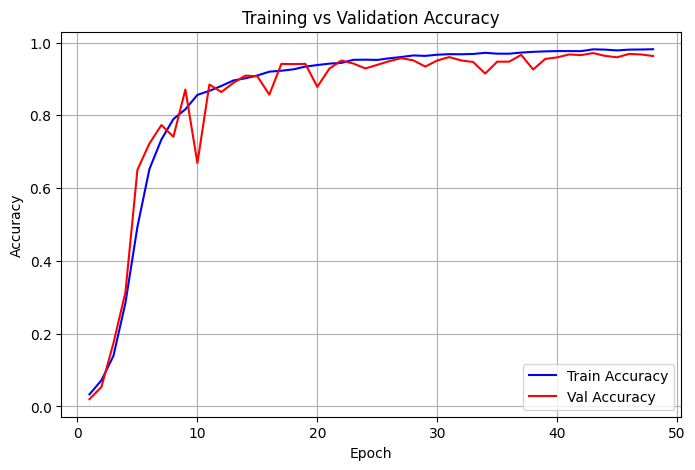

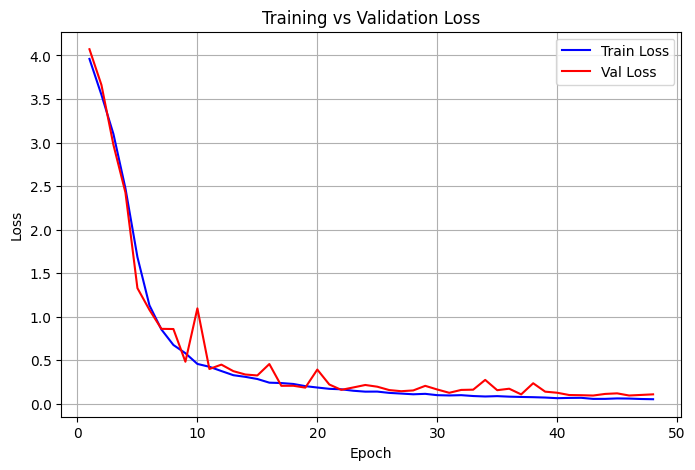

In [ ]:
import re, matplotlib.pyplot as plt

log_text = """558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - aux_output_accuracy: 0.0281 - aux_output_loss: 4.0153 - loss: 5.2421 - main_output_accuracy: 0.0331 - main_output_loss: 3.9610
Epoch 1: val_main_output_accuracy improved from -inf to 0.01982, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 251s 380ms/step - aux_output_accuracy: 0.0281 - aux_output_loss: 4.0151 - loss: 5.2418 - main_output_accuracy: 0.0332 - main_output_loss: 3.9608 - val_aux_output_accuracy: 0.0210 - val_aux_output_loss: 3.9435 - val_loss: 5.3295 - val_main_output_accuracy: 0.0198 - val_main_output_loss: 4.0720 - learning_rate: 1.0000e-04
Epoch 2/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - aux_output_accuracy: 0.0633 - aux_output_loss: 3.7085 - loss: 4.7305 - main_output_accuracy: 0.0718 - main_output_loss: 3.5482
Epoch 2: val_main_output_accuracy improved from 0.01982 to 0.05371, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 182s 326ms/step - aux_output_accuracy: 0.0633 - aux_output_loss: 3.7084 - loss: 4.7302 - main_output_accuracy: 0.0718 - main_output_loss: 3.5480 - val_aux_output_accuracy: 0.1047 - val_aux_output_loss: 3.6474 - val_loss: 4.8228 - val_main_output_accuracy: 0.0537 - val_main_output_loss: 3.6614 - learning_rate: 1.0000e-04
Epoch 3/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - aux_output_accuracy: 0.1224 - aux_output_loss: 3.3198 - loss: 4.1606 - main_output_accuracy: 0.1390 - main_output_loss: 3.0981
Epoch 3: val_main_output_accuracy improved from 0.05371 to 0.17402, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 182s 327ms/step - aux_output_accuracy: 0.1225 - aux_output_loss: 3.3197 - loss: 4.1603 - main_output_accuracy: 0.1391 - main_output_loss: 3.0979 - val_aux_output_accuracy: 0.1549 - val_aux_output_loss: 3.2091 - val_loss: 4.0011 - val_main_output_accuracy: 0.1740 - val_main_output_loss: 2.9733 - learning_rate: 9.0000e-05
Epoch 4/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - aux_output_accuracy: 0.1991 - aux_output_loss: 2.9511 - loss: 3.4251 - main_output_accuracy: 0.2846 - main_output_loss: 2.4750
Epoch 4: val_main_output_accuracy improved from 0.17402 to 0.31387, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 181s 324ms/step - aux_output_accuracy: 0.1992 - aux_output_loss: 2.9509 - loss: 3.4246 - main_output_accuracy: 0.2847 - main_output_loss: 2.4747 - val_aux_output_accuracy: 0.2562 - val_aux_output_loss: 2.8277 - val_loss: 3.3386 - val_main_output_accuracy: 0.3139 - val_main_output_loss: 2.4264 - learning_rate: 9.0000e-05
Epoch 5/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - aux_output_accuracy: 0.3102 - aux_output_loss: 2.4493 - loss: 2.4838 - main_output_accuracy: 0.4936 - main_output_loss: 1.6855
Epoch 5: val_main_output_accuracy improved from 0.31387 to 0.65020, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 177s 317ms/step - aux_output_accuracy: 0.3102 - aux_output_loss: 2.4491 - loss: 2.4835 - main_output_accuracy: 0.4936 - main_output_loss: 1.6852 - val_aux_output_accuracy: 0.4850 - val_aux_output_loss: 2.0639 - val_loss: 2.0109 - val_main_output_accuracy: 0.6502 - val_main_output_loss: 1.3289 - learning_rate: 9.0000e-05
Epoch 6/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - aux_output_accuracy: 0.4142 - aux_output_loss: 2.0176 - loss: 1.8003 - main_output_accuracy: 0.6523 - main_output_loss: 1.1323
Epoch 6: val_main_output_accuracy improved from 0.65020 to 0.72246, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 176s 316ms/step - aux_output_accuracy: 0.4143 - aux_output_loss: 2.0175 - loss: 1.8001 - main_output_accuracy: 0.6523 - main_output_loss: 1.1322 - val_aux_output_accuracy: 0.5549 - val_aux_output_loss: 1.7931 - val_loss: 1.6799 - val_main_output_accuracy: 0.7225 - val_main_output_loss: 1.0799 - learning_rate: 8.1000e-05
Epoch 7/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - aux_output_accuracy: 0.4992 - aux_output_loss: 1.7137 - loss: 1.4302 - main_output_accuracy: 0.7336 - main_output_loss: 0.8543
Epoch 7: val_main_output_accuracy improved from 0.72246 to 0.77324, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 176s 316ms/step - aux_output_accuracy: 0.4992 - aux_output_loss: 1.7136 - loss: 1.4301 - main_output_accuracy: 0.7337 - main_output_loss: 0.8542 - val_aux_output_accuracy: 0.6031 - val_aux_output_loss: 1.5626 - val_loss: 1.3915 - val_main_output_accuracy: 0.7732 - val_main_output_loss: 0.8615 - learning_rate: 8.1000e-05
Epoch 8/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - aux_output_accuracy: 0.5596 - aux_output_loss: 1.4721 - loss: 1.1790 - main_output_accuracy: 0.7897 - main_output_loss: 0.6763
Epoch 8: val_main_output_accuracy did not improve from 0.77324
558/558 ━━━━━━━━━━━━━━━━━━━━ 184s 330ms/step - aux_output_accuracy: 0.5597 - aux_output_loss: 1.4720 - loss: 1.1789 - main_output_accuracy: 0.7898 - main_output_loss: 0.6763 - val_aux_output_accuracy: 0.5766 - val_aux_output_loss: 1.5081 - val_loss: 1.3724 - val_main_output_accuracy: 0.7410 - val_main_output_loss: 0.8594 - learning_rate: 8.1000e-05
Epoch 9/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - aux_output_accuracy: 0.6106 - aux_output_loss: 1.3002 - loss: 1.0322 - main_output_accuracy: 0.8166 - main_output_loss: 0.5818
Epoch 9: val_main_output_accuracy improved from 0.77324 to 0.87090, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 178s 320ms/step - aux_output_accuracy: 0.6107 - aux_output_loss: 1.3001 - loss: 1.0321 - main_output_accuracy: 0.8166 - main_output_loss: 0.5817 - val_aux_output_accuracy: 0.7367 - val_aux_output_loss: 1.0419 - val_loss: 0.8562 - val_main_output_accuracy: 0.8709 - val_main_output_loss: 0.4838 - learning_rate: 7.2900e-05
Epoch 10/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - aux_output_accuracy: 0.6584 - aux_output_loss: 1.1325 - loss: 0.8582 - main_output_accuracy: 0.8561 - main_output_loss: 0.4587
Epoch 10: val_main_output_accuracy did not improve from 0.87090
558/558 ━━━━━━━━━━━━━━━━━━━━ 178s 320ms/step - aux_output_accuracy: 0.6584 - aux_output_loss: 1.1325 - loss: 0.8582 - main_output_accuracy: 0.8561 - main_output_loss: 0.4587 - val_aux_output_accuracy: 0.5410 - val_aux_output_loss: 1.5699 - val_loss: 1.6272 - val_main_output_accuracy: 0.6687 - val_main_output_loss: 1.0970 - learning_rate: 7.2900e-05
Epoch 11/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - aux_output_accuracy: 0.6831 - aux_output_loss: 1.0369 - loss: 0.7964 - main_output_accuracy: 0.8672 - main_output_loss: 0.4262
Epoch 11: val_main_output_accuracy improved from 0.87090 to 0.88457, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 178s 319ms/step - aux_output_accuracy: 0.6831 - aux_output_loss: 1.0369 - loss: 0.7964 - main_output_accuracy: 0.8672 - main_output_loss: 0.4262 - val_aux_output_accuracy: 0.7674 - val_aux_output_loss: 0.8542 - val_loss: 0.7156 - val_main_output_accuracy: 0.8846 - val_main_output_loss: 0.4006 - learning_rate: 7.2900e-05
Epoch 12/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - aux_output_accuracy: 0.7090 - aux_output_loss: 0.9610 - loss: 0.7240 - main_output_accuracy: 0.8807 - main_output_loss: 0.3772
Epoch 12: val_main_output_accuracy did not improve from 0.88457
558/558 ━━━━━━━━━━━━━━━━━━━━ 177s 318ms/step - aux_output_accuracy: 0.7090 - aux_output_loss: 0.9610 - loss: 0.7240 - main_output_accuracy: 0.8807 - main_output_loss: 0.3772 - val_aux_output_accuracy: 0.7398 - val_aux_output_loss: 0.9167 - val_loss: 0.7839 - val_main_output_accuracy: 0.8639 - val_main_output_loss: 0.4508 - learning_rate: 6.5610e-05
Epoch 13/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - aux_output_accuracy: 0.7283 - aux_output_loss: 0.8742 - loss: 0.6495 - main_output_accuracy: 0.8957 - main_output_loss: 0.3293
Epoch 13: val_main_output_accuracy improved from 0.88457 to 0.88906, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 178s 320ms/step - aux_output_accuracy: 0.7283 - aux_output_loss: 0.8742 - loss: 0.6495 - main_output_accuracy: 0.8957 - main_output_loss: 0.3293 - val_aux_output_accuracy: 0.8256 - val_aux_output_loss: 0.6759 - val_loss: 0.6361 - val_main_output_accuracy: 0.8891 - val_main_output_loss: 0.3757 - learning_rate: 6.5610e-05
Epoch 14/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - aux_output_accuracy: 0.7466 - aux_output_loss: 0.8160 - loss: 0.6125 - main_output_accuracy: 0.9017 - main_output_loss: 0.3103
Epoch 14: val_main_output_accuracy improved from 0.88906 to 0.90898, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 178s 319ms/step - aux_output_accuracy: 0.7466 - aux_output_loss: 0.8159 - loss: 0.6125 - main_output_accuracy: 0.9017 - main_output_loss: 0.3103 - val_aux_output_accuracy: 0.8211 - val_aux_output_loss: 0.6564 - val_loss: 0.5912 - val_main_output_accuracy: 0.9090 - val_main_output_loss: 0.3372 - learning_rate: 6.5610e-05
Epoch 15/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - aux_output_accuracy: 0.7658 - aux_output_loss: 0.7473 - loss: 0.5669 - main_output_accuracy: 0.9094 - main_output_loss: 0.2857
Epoch 15: val_main_output_accuracy did not improve from 0.90898
558/558 ━━━━━━━━━━━━━━━━━━━━ 176s 315ms/step - aux_output_accuracy: 0.7658 - aux_output_loss: 0.7473 - loss: 0.5669 - main_output_accuracy: 0.9094 - main_output_loss: 0.2857 - val_aux_output_accuracy: 0.8051 - val_aux_output_loss: 0.6881 - val_loss: 0.5894 - val_main_output_accuracy: 0.9072 - val_main_output_loss: 0.3264 - learning_rate: 5.9049e-05
Epoch 16/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - aux_output_accuracy: 0.7846 - aux_output_loss: 0.7015 - loss: 0.5105 - main_output_accuracy: 0.9199 - main_output_loss: 0.2435
Epoch 16: val_main_output_accuracy did not improve from 0.90898
558/558 ━━━━━━━━━━━━━━━━━━━━ 180s 322ms/step - aux_output_accuracy: 0.7846 - aux_output_loss: 0.7015 - loss: 0.5105 - main_output_accuracy: 0.9199 - main_output_loss: 0.2435 - val_aux_output_accuracy: 0.7682 - val_aux_output_loss: 0.8256 - val_loss: 0.7615 - val_main_output_accuracy: 0.8568 - val_main_output_loss: 0.4576 - learning_rate: 5.9049e-05
Epoch 17/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - aux_output_accuracy: 0.7912 - aux_output_loss: 0.6694 - loss: 0.4961 - main_output_accuracy: 0.9225 - main_output_loss: 0.2391
Epoch 17: val_main_output_accuracy improved from 0.90898 to 0.94121, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 182s 326ms/step - aux_output_accuracy: 0.7912 - aux_output_loss: 0.6694 - loss: 0.4960 - main_output_accuracy: 0.9225 - main_output_loss: 0.2391 - val_aux_output_accuracy: 0.8602 - val_aux_output_loss: 0.5082 - val_loss: 0.4158 - val_main_output_accuracy: 0.9412 - val_main_output_loss: 0.2075 - learning_rate: 5.9049e-05
Epoch 18/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - aux_output_accuracy: 0.8024 - aux_output_loss: 0.6293 - loss: 0.4732 - main_output_accuracy: 0.9263 - main_output_loss: 0.2287
Epoch 18: val_main_output_accuracy did not improve from 0.94121
558/558 ━━━━━━━━━━━━━━━━━━━━ 176s 315ms/step - aux_output_accuracy: 0.8024 - aux_output_loss: 0.6293 - loss: 0.4732 - main_output_accuracy: 0.9263 - main_output_loss: 0.2287 - val_aux_output_accuracy: 0.8613 - val_aux_output_loss: 0.4880 - val_loss: 0.4099 - val_main_output_accuracy: 0.9408 - val_main_output_loss: 0.2081 - learning_rate: 5.3144e-05
Epoch 19/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - aux_output_accuracy: 0.8191 - aux_output_loss: 0.5693 - loss: 0.4299 - main_output_accuracy: 0.9338 - main_output_loss: 0.2037
Epoch 19: val_main_output_accuracy improved from 0.94121 to 0.94134, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 176s 316ms/step - aux_output_accuracy: 0.8191 - aux_output_loss: 0.5693 - loss: 0.4299 - main_output_accuracy: 0.9338 - main_output_loss: 0.2037 - val_aux_output_accuracy: 0.8738 - val_aux_output_loss: 0.4432 - val_loss: 0.3759 - val_main_output_accuracy: 0.9413 - val_main_output_loss: 0.1866 - learning_rate: 5.3144e-05
Epoch 20/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - aux_output_accuracy: 0.8246 - aux_output_loss: 0.5361 - loss: 0.4036 - main_output_accuracy: 0.9381 - main_output_loss: 0.1878
Epoch 20: val_main_output_accuracy did not improve from 0.94134
558/558 ━━━━━━━━━━━━━━━━━━━━ 176s 316ms/step - aux_output_accuracy: 0.8246 - aux_output_loss: 0.5361 - loss: 0.4036 - main_output_accuracy: 0.9381 - main_output_loss: 0.1878 - val_aux_output_accuracy: 0.7638 - val_aux_output_loss: 0.7732 - val_loss: 0.6829 - val_main_output_accuracy: 0.8782 - val_main_output_loss: 0.3941 - learning_rate: 5.3144e-05
Epoch 21/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - aux_output_accuracy: 0.8285 - aux_output_loss: 0.5283 - loss: 0.3859 - main_output_accuracy: 0.9420 - main_output_loss: 0.1728
Epoch 21: val_main_output_accuracy did not improve from 0.94134
558/558 ━━━━━━━━━━━━━━━━━━━━ 177s 318ms/step - aux_output_accuracy: 0.8285 - aux_output_loss: 0.5283 - loss: 0.3859 - main_output_accuracy: 0.9420 - main_output_loss: 0.1728 - val_aux_output_accuracy: 0.8360 - val_aux_output_loss: 0.5396 - val_loss: 0.4401 - val_main_output_accuracy: 0.9280 - val_main_output_loss: 0.2226 - learning_rate: 4.7830e-05
Epoch 22/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - aux_output_accuracy: 0.8366 - aux_output_loss: 0.5087 - loss: 0.3744 - main_output_accuracy: 0.9440 - main_output_loss: 0.1675
Epoch 22: val_main_output_accuracy improved from 0.94134 to 0.95056, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 177s 318ms/step - aux_output_accuracy: 0.8366 - aux_output_loss: 0.5087 - loss: 0.3744 - main_output_accuracy: 0.9440 - main_output_loss: 0.1675 - val_aux_output_accuracy: 0.8872 - val_aux_output_loss: 0.3848 - val_loss: 0.3309 - val_main_output_accuracy: 0.9506 - val_main_output_loss: 0.1610 - learning_rate: 4.7830e-05
Epoch 23/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - aux_output_accuracy: 0.8513 - aux_output_loss: 0.4655 - loss: 0.3443 - main_output_accuracy: 0.9524 - main_output_loss: 0.1507
Epoch 23: val_main_output_accuracy did not improve from 0.95056
558/558 ━━━━━━━━━━━━━━━━━━━━ 177s 318ms/step - aux_output_accuracy: 0.8513 - aux_output_loss: 0.4655 - loss: 0.3443 - main_output_accuracy: 0.9524 - main_output_loss: 0.1507 - val_aux_output_accuracy: 0.8748 - val_aux_output_loss: 0.4322 - val_loss: 0.3730 - val_main_output_accuracy: 0.9423 - val_main_output_loss: 0.1886 - learning_rate: 4.7830e-05
Epoch 24/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - aux_output_accuracy: 0.8583 - aux_output_loss: 0.4512 - loss: 0.3294 - main_output_accuracy: 0.9529 - main_output_loss: 0.1405
Epoch 24: val_main_output_accuracy did not improve from 0.95056
558/558 ━━━━━━━━━━━━━━━━━━━━ 178s 319ms/step - aux_output_accuracy: 0.8583 - aux_output_loss: 0.4513 - loss: 0.3294 - main_output_accuracy: 0.9529 - main_output_loss: 0.1405 - val_aux_output_accuracy: 0.8603 - val_aux_output_loss: 0.4600 - val_loss: 0.4099 - val_main_output_accuracy: 0.9288 - val_main_output_loss: 0.2170 - learning_rate: 4.3047e-05
Epoch 25/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - aux_output_accuracy: 0.8613 - aux_output_loss: 0.4384 - loss: 0.3259 - main_output_accuracy: 0.9522 - main_output_loss: 0.1411
Epoch 25: val_main_output_accuracy did not improve from 0.95056
558/558 ━━━━━━━━━━━━━━━━━━━━ 175s 314ms/step - aux_output_accuracy: 0.8613 - aux_output_loss: 0.4384 - loss: 0.3259 - main_output_accuracy: 0.9522 - main_output_loss: 0.1411 - val_aux_output_accuracy: 0.8723 - val_aux_output_loss: 0.4438 - val_loss: 0.3848 - val_main_output_accuracy: 0.9386 - val_main_output_loss: 0.1973 - learning_rate: 4.3047e-05
Epoch 26/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - aux_output_accuracy: 0.8655 - aux_output_loss: 0.4221 - loss: 0.3058 - main_output_accuracy: 0.9567 - main_output_loss: 0.1262
Epoch 26: val_main_output_accuracy did not improve from 0.95056
558/558 ━━━━━━━━━━━━━━━━━━━━ 178s 318ms/step - aux_output_accuracy: 0.8655 - aux_output_loss: 0.4221 - loss: 0.3058 - main_output_accuracy: 0.9567 - main_output_loss: 0.1262 - val_aux_output_accuracy: 0.8880 - val_aux_output_loss: 0.3784 - val_loss: 0.3258 - val_main_output_accuracy: 0.9488 - val_main_output_loss: 0.1585 - learning_rate: 4.3047e-05
Epoch 27/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - aux_output_accuracy: 0.8744 - aux_output_loss: 0.3920 - loss: 0.2887 - main_output_accuracy: 0.9602 - main_output_loss: 0.1184
Epoch 27: val_main_output_accuracy improved from 0.95056 to 0.95703, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 176s 315ms/step - aux_output_accuracy: 0.8744 - aux_output_loss: 0.3920 - loss: 0.2887 - main_output_accuracy: 0.9602 - main_output_loss: 0.1184 - val_aux_output_accuracy: 0.8890 - val_aux_output_loss: 0.3684 - val_loss: 0.3091 - val_main_output_accuracy: 0.9570 - val_main_output_loss: 0.1456 - learning_rate: 3.8742e-05
Epoch 28/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - aux_output_accuracy: 0.8753 - aux_output_loss: 0.3794 - loss: 0.2764 - main_output_accuracy: 0.9645 - main_output_loss: 0.1102
Epoch 28: val_main_output_accuracy did not improve from 0.95703
558/558 ━━━━━━━━━━━━━━━━━━━━ 178s 320ms/step - aux_output_accuracy: 0.8753 - aux_output_loss: 0.3794 - loss: 0.2764 - main_output_accuracy: 0.9645 - main_output_loss: 0.1102 - val_aux_output_accuracy: 0.8984 - val_aux_output_loss: 0.3466 - val_loss: 0.3115 - val_main_output_accuracy: 0.9511 - val_main_output_loss: 0.1544 - learning_rate: 3.8742e-05
Epoch 29/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - aux_output_accuracy: 0.8779 - aux_output_loss: 0.3723 - loss: 0.2790 - main_output_accuracy: 0.9633 - main_output_loss: 0.1153
Epoch 29: val_main_output_accuracy did not improve from 0.95703
558/558 ━━━━━━━━━━━━━━━━━━━━ 178s 319ms/step - aux_output_accuracy: 0.8779 - aux_output_loss: 0.3723 - loss: 0.2790 - main_output_accuracy: 0.9633 - main_output_loss: 0.1153 - val_aux_output_accuracy: 0.8803 - val_aux_output_loss: 0.4019 - val_loss: 0.3808 - val_main_output_accuracy: 0.9339 - val_main_output_loss: 0.2071 - learning_rate: 3.8742e-05
Epoch 30/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - aux_output_accuracy: 0.8812 - aux_output_loss: 0.3631 - loss: 0.2608 - main_output_accuracy: 0.9665 - main_output_loss: 0.1000
Epoch 30: val_main_output_accuracy did not improve from 0.95703
558/558 ━━━━━━━━━━━━━━━━━━━━ 179s 321ms/step - aux_output_accuracy: 0.8812 - aux_output_loss: 0.3631 - loss: 0.2608 - main_output_accuracy: 0.9665 - main_output_loss: 0.1000 - val_aux_output_accuracy: 0.8966 - val_aux_output_loss: 0.3476 - val_loss: 0.3220 - val_main_output_accuracy: 0.9506 - val_main_output_loss: 0.1653 - learning_rate: 3.4868e-05
Epoch 31/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - aux_output_accuracy: 0.8911 - aux_output_loss: 0.3354 - loss: 0.2488 - main_output_accuracy: 0.9680 - main_output_loss: 0.0967
Epoch 31: val_main_output_accuracy improved from 0.95703 to 0.95998, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 175s 314ms/step - aux_output_accuracy: 0.8911 - aux_output_loss: 0.3354 - loss: 0.2489 - main_output_accuracy: 0.9680 - main_output_loss: 0.0967 - val_aux_output_accuracy: 0.9066 - val_aux_output_loss: 0.3132 - val_loss: 0.2734 - val_main_output_accuracy: 0.9600 - val_main_output_loss: 0.1273 - learning_rate: 3.4868e-05
Epoch 32/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - aux_output_accuracy: 0.8857 - aux_output_loss: 0.3495 - loss: 0.2563 - main_output_accuracy: 0.9677 - main_output_loss: 0.1001
Epoch 32: val_main_output_accuracy did not improve from 0.95998
558/558 ━━━━━━━━━━━━━━━━━━━━ 175s 314ms/step - aux_output_accuracy: 0.8857 - aux_output_loss: 0.3495 - loss: 0.2563 - main_output_accuracy: 0.9677 - main_output_loss: 0.1001 - val_aux_output_accuracy: 0.9054 - val_aux_output_loss: 0.3228 - val_loss: 0.3091 - val_main_output_accuracy: 0.9508 - val_main_output_loss: 0.1603 - learning_rate: 3.4868e-05
Epoch 33/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - aux_output_accuracy: 0.8894 - aux_output_loss: 0.3310 - loss: 0.2406 - main_output_accuracy: 0.9686 - main_output_loss: 0.0902
Epoch 33: val_main_output_accuracy did not improve from 0.95998
558/558 ━━━━━━━━━━━━━━━━━━━━ 174s 312ms/step - aux_output_accuracy: 0.8894 - aux_output_loss: 0.3310 - loss: 0.2406 - main_output_accuracy: 0.9686 - main_output_loss: 0.0902 - val_aux_output_accuracy: 0.8976 - val_aux_output_loss: 0.3392 - val_loss: 0.3170 - val_main_output_accuracy: 0.9464 - val_main_output_loss: 0.1632 - learning_rate: 3.1381e-05
Epoch 34/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - aux_output_accuracy: 0.9010 - aux_output_loss: 0.3169 - loss: 0.2308 - main_output_accuracy: 0.9717 - main_output_loss: 0.0849
Epoch 34: val_main_output_accuracy did not improve from 0.95998
558/558 ━━━━━━━━━━━━━━━━━━━━ 173s 311ms/step - aux_output_accuracy: 0.9010 - aux_output_loss: 0.3169 - loss: 0.2308 - main_output_accuracy: 0.9717 - main_output_loss: 0.0849 - val_aux_output_accuracy: 0.8462 - val_aux_output_loss: 0.5009 - val_loss: 0.4781 - val_main_output_accuracy: 0.9147 - val_main_output_loss: 0.2754 - learning_rate: 3.1381e-05
Epoch 35/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - aux_output_accuracy: 0.8940 - aux_output_loss: 0.3290 - loss: 0.2382 - main_output_accuracy: 0.9694 - main_output_loss: 0.0889
Epoch 35: val_main_output_accuracy did not improve from 0.95998
558/558 ━━━━━━━━━━━━━━━━━━━━ 178s 319ms/step - aux_output_accuracy: 0.8940 - aux_output_loss: 0.3290 - loss: 0.2382 - main_output_accuracy: 0.9694 - main_output_loss: 0.0889 - val_aux_output_accuracy: 0.8980 - val_aux_output_loss: 0.3322 - val_loss: 0.3083 - val_main_output_accuracy: 0.9474 - val_main_output_loss: 0.1572 - learning_rate: 3.1381e-05
Epoch 36/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - aux_output_accuracy: 0.9045 - aux_output_loss: 0.2883 - loss: 0.2199 - main_output_accuracy: 0.9693 - main_output_loss: 0.0830
Epoch 36: val_main_output_accuracy did not improve from 0.95998
558/558 ━━━━━━━━━━━━━━━━━━━━ 177s 317ms/step - aux_output_accuracy: 0.9045 - aux_output_loss: 0.2883 - loss: 0.2199 - main_output_accuracy: 0.9693 - main_output_loss: 0.0830 - val_aux_output_accuracy: 0.8852 - val_aux_output_loss: 0.3780 - val_loss: 0.3385 - val_main_output_accuracy: 0.9474 - val_main_output_loss: 0.1741 - learning_rate: 2.8243e-05
Epoch 37/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - aux_output_accuracy: 0.9070 - aux_output_loss: 0.2782 - loss: 0.2131 - main_output_accuracy: 0.9724 - main_output_loss: 0.0795
Epoch 37: val_main_output_accuracy improved from 0.95998 to 0.96606, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 176s 316ms/step - aux_output_accuracy: 0.9070 - aux_output_loss: 0.2782 - loss: 0.2131 - main_output_accuracy: 0.9724 - main_output_loss: 0.0795 - val_aux_output_accuracy: 0.9160 - val_aux_output_loss: 0.2770 - val_loss: 0.2429 - val_main_output_accuracy: 0.9661 - val_main_output_loss: 0.1090 - learning_rate: 2.8243e-05
Epoch 38/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - aux_output_accuracy: 0.9074 - aux_output_loss: 0.2865 - loss: 0.2128 - main_output_accuracy: 0.9744 - main_output_loss: 0.0769
Epoch 38: val_main_output_accuracy did not improve from 0.96606
558/558 ━━━━━━━━━━━━━━━━━━━━ 177s 317ms/step - aux_output_accuracy: 0.9074 - aux_output_loss: 0.2865 - loss: 0.2128 - main_output_accuracy: 0.9744 - main_output_loss: 0.0769 - val_aux_output_accuracy: 0.8387 - val_aux_output_loss: 0.5195 - val_loss: 0.4440 - val_main_output_accuracy: 0.9258 - val_main_output_loss: 0.2369 - learning_rate: 2.8243e-05
Epoch 39/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - aux_output_accuracy: 0.9118 - aux_output_loss: 0.2704 - loss: 0.2036 - main_output_accuracy: 0.9757 - main_output_loss: 0.0727
Epoch 39: val_main_output_accuracy did not improve from 0.96606
558/558 ━━━━━━━━━━━━━━━━━━━━ 176s 315ms/step - aux_output_accuracy: 0.9118 - aux_output_loss: 0.2705 - loss: 0.2036 - main_output_accuracy: 0.9757 - main_output_loss: 0.0727 - val_aux_output_accuracy: 0.9062 - val_aux_output_loss: 0.3116 - val_loss: 0.2843 - val_main_output_accuracy: 0.9549 - val_main_output_loss: 0.1403 - learning_rate: 2.5419e-05
Epoch 40/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - aux_output_accuracy: 0.9112 - aux_output_loss: 0.2609 - loss: 0.1933 - main_output_accuracy: 0.9765 - main_output_loss: 0.0655
Epoch 40: val_main_output_accuracy did not improve from 0.96606
558/558 ━━━━━━━━━━━━━━━━━━━━ 173s 310ms/step - aux_output_accuracy: 0.9111 - aux_output_loss: 0.2609 - loss: 0.1933 - main_output_accuracy: 0.9765 - main_output_loss: 0.0655 - val_aux_output_accuracy: 0.9066 - val_aux_output_loss: 0.3109 - val_loss: 0.2713 - val_main_output_accuracy: 0.9592 - val_main_output_loss: 0.1279 - learning_rate: 2.5419e-05
Epoch 41/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - aux_output_accuracy: 0.9094 - aux_output_loss: 0.2682 - loss: 0.1983 - main_output_accuracy: 0.9765 - main_output_loss: 0.0685
Epoch 41: val_main_output_accuracy improved from 0.96606 to 0.96724, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 176s 316ms/step - aux_output_accuracy: 0.9094 - aux_output_loss: 0.2682 - loss: 0.1983 - main_output_accuracy: 0.9765 - main_output_loss: 0.0685 - val_aux_output_accuracy: 0.9307 - val_aux_output_loss: 0.2365 - val_loss: 0.2226 - val_main_output_accuracy: 0.9672 - val_main_output_loss: 0.1018 - learning_rate: 2.5419e-05
Epoch 42/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - aux_output_accuracy: 0.9081 - aux_output_loss: 0.2643 - loss: 0.1982 - main_output_accuracy: 0.9763 - main_output_loss: 0.0697
Epoch 42: val_main_output_accuracy did not improve from 0.96724
558/558 ━━━━━━━━━━━━━━━━━━━━ 174s 313ms/step - aux_output_accuracy: 0.9081 - aux_output_loss: 0.2643 - loss: 0.1982 - main_output_accuracy: 0.9763 - main_output_loss: 0.0697 - val_aux_output_accuracy: 0.9254 - val_aux_output_loss: 0.2460 - val_loss: 0.2231 - val_main_output_accuracy: 0.9655 - val_main_output_loss: 0.0996 - learning_rate: 2.2877e-05
Epoch 43/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - aux_output_accuracy: 0.9146 - aux_output_loss: 0.2508 - loss: 0.1817 - main_output_accuracy: 0.9813 - main_output_loss: 0.0574
Epoch 43: val_main_output_accuracy improved from 0.96724 to 0.97096, saving model to checkpoints/best_model.weights.h5
558/558 ━━━━━━━━━━━━━━━━━━━━ 179s 322ms/step - aux_output_accuracy: 0.9146 - aux_output_loss: 0.2508 - loss: 0.1817 - main_output_accuracy: 0.9813 - main_output_loss: 0.0574 - val_aux_output_accuracy: 0.9280 - val_aux_output_loss: 0.2446 - val_loss: 0.2187 - val_main_output_accuracy: 0.9710 - val_main_output_loss: 0.0958 - learning_rate: 2.2877e-05
Epoch 44/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - aux_output_accuracy: 0.9155 - aux_output_loss: 0.2529 - loss: 0.1822 - main_output_accuracy: 0.9805 - main_output_loss: 0.0576
Epoch 44: val_main_output_accuracy did not improve from 0.97096
558/558 ━━━━━━━━━━━━━━━━━━━━ 177s 318ms/step - aux_output_accuracy: 0.9155 - aux_output_loss: 0.2529 - loss: 0.1822 - main_output_accuracy: 0.9805 - main_output_loss: 0.0576 - val_aux_output_accuracy: 0.9217 - val_aux_output_loss: 0.2677 - val_loss: 0.2441 - val_main_output_accuracy: 0.9633 - val_main_output_loss: 0.1143 - learning_rate: 2.2877e-05
Epoch 45/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - aux_output_accuracy: 0.9166 - aux_output_loss: 0.2457 - loss: 0.1850 - main_output_accuracy: 0.9783 - main_output_loss: 0.0627
Epoch 45: val_main_output_accuracy did not improve from 0.97096
558/558 ━━━━━━━━━━━━━━━━━━━━ 177s 318ms/step - aux_output_accuracy: 0.9166 - aux_output_loss: 0.2457 - loss: 0.1850 - main_output_accuracy: 0.9783 - main_output_loss: 0.0627 - val_aux_output_accuracy: 0.9149 - val_aux_output_loss: 0.2766 - val_loss: 0.2532 - val_main_output_accuracy: 0.9594 - val_main_output_loss: 0.1209 - learning_rate: 2.0589e-05
Epoch 46/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - aux_output_accuracy: 0.9259 - aux_output_loss: 0.2305 - loss: 0.1788 - main_output_accuracy: 0.9805 - main_output_loss: 0.0611
Epoch 46: val_main_output_accuracy did not improve from 0.97096
558/558 ━━━━━━━━━━━━━━━━━━━━ 178s 319ms/step - aux_output_accuracy: 0.9259 - aux_output_loss: 0.2305 - loss: 0.1787 - main_output_accuracy: 0.9805 - main_output_loss: 0.0611 - val_aux_output_accuracy: 0.9286 - val_aux_output_loss: 0.2356 - val_loss: 0.2159 - val_main_output_accuracy: 0.9686 - val_main_output_loss: 0.0962 - learning_rate: 2.0589e-05
Epoch 47/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - aux_output_accuracy: 0.9222 - aux_output_loss: 0.2295 - loss: 0.1732 - main_output_accuracy: 0.9808 - main_output_loss: 0.0561
Epoch 47: val_main_output_accuracy did not improve from 0.97096
558/558 ━━━━━━━━━━━━━━━━━━━━ 176s 317ms/step - aux_output_accuracy: 0.9222 - aux_output_loss: 0.2295 - loss: 0.1732 - main_output_accuracy: 0.9808 - main_output_loss: 0.0561 - val_aux_output_accuracy: 0.9217 - val_aux_output_loss: 0.2567 - val_loss: 0.2285 - val_main_output_accuracy: 0.9672 - val_main_output_loss: 0.1028 - learning_rate: 2.0589e-05
Epoch 48/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - aux_output_accuracy: 0.9209 - aux_output_loss: 0.2351 - loss: 0.1722 - main_output_accuracy: 0.9816 - main_output_loss: 0.0535
Epoch 48: val_main_output_accuracy did not improve from 0.97096
558/558 ━━━━━━━━━━━━━━━━━━━━ 176s 316ms/step - aux_output_accuracy: 0.9209 - aux_output_loss: 0.2351 - loss: 0.1722 - main_output_accuracy: 0.9816 - main_output_loss: 0.0535 - val_aux_output_accuracy: 0.9200 - val_aux_output_loss: 0.2564 - val_loss: 0.2352 - val_main_output_accuracy: 0.9629 - val_main_output_loss: 0.1094 - learning_rate: 1.8530e-05
Epoch 49/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - aux_output_accuracy: 0.9208 - aux_output_loss: 0.2368 - loss: 0.1752 - main_output_accuracy: 0.9816 - main_output_loss: 0.0561
Epoch 49: val_main_output_accuracy did not improve from 0.97096"""


train_acc, val_acc = [], []
train_loss, val_loss = [], []   

epoch_blocks = re.split(r"Epoch \d+/\d+", log_text)

for block in epoch_blocks:
    
    train_match = re.search(r"main_output_accuracy:\s*([0-9.]+).*?main_output_loss:\s*([0-9.]+)", block, re.S)
    
    val_match = re.search(r"val_main_output_accuracy:\s*([0-9.]+).*?val_main_output_loss:\s*([0-9.]+)", block, re.S)

    if train_match and val_match:
        train_acc.append(float(train_match.group(1)))
        train_loss.append(float(train_match.group(2)))
        val_acc.append(float(val_match.group(1)))
        val_loss.append(float(val_match.group(2)))

epochs = range(1, len(train_acc)+1)
print(f"✅ Clean data extracted for {len(train_acc)} epochs")

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, 'b-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r-', label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
